In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Home'
ODDS = 'Odds_H'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')
data = prepara_df(data)

In [4]:
def prepara_dataset(_df):
    _df = _df[_df['Odds_H'] != 0]

    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    # _df.dropna(subset=['Avg_CG_H', 'Avg_CG_A', TARGET], inplace=True)

    _df.reset_index(drop=True, inplace=True)

    return _df

In [5]:
df = data.copy()
df = prepara_dataset(df)

In [7]:
treinamento = df[df['Date'] < '2023-11-01']
val = df[df['Date'] >= '2023-11-01']
val = val[val['Date'] < '2023-12-09']

print(f'Treino: {treinamento.shape[0]} | Validação: {val.shape[0]}')

Treino: 5538 | Validação: 4983


# Criação do modelo

In [8]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Avg_CG_H',
       'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H', 'DP_Pontos_H', 'CV_Pontos_H',
       'CG_H_Last_Game', 'Media_Odds_Geral_H', 'DP_Odds_Geral_H',
       'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A',
       'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A', 'CG_A_Last_Game',
       'Media_Odds_Geral_A', 'DP_Odds_Geral_A', 'CV_Odds_Geral_A',
       'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A', 'Last_Odd_H',
       'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA']

features = ['P(H)', 'P(A)', 'Over_Line', 'HA_Line', 'P_Diff', 'CG_H_Last_Game', 'CG_A_Last_Game', 'CV_ML', ]

In [ ]:
# Ranges da variável
ranges_dict['P(A)']['range']

In [9]:
def filtra_resultados(_df, filtro = 0):

    if filtro == 1:
        _df = _df[(_df['P(H)'] > 0.35) & (_df['P(H)'] < 0.65)]
        _df = _df[(_df['CG_H_Last_Game'] > 0) & (_df['CG_H_Last_Game'] <= 170)]
        _df = _df[(_df['CG_A_Last_Game'] > 160)]
        
        # _df = _df[(_df['HA_Line'] < -1.5)]

    return _df

In [10]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    _df['Acumulado'] = _df['PL_BF_Predictions'].cumsum()
    _df['Drawdown'] = _df['Acumulado'] - _df['Acumulado'].cummax()
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    dd = _df['Drawdown'].min()

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'Máx Drawndown: {dd:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = {
            'pl': plb,
            'wr': wr,
            'dd': dd,
            'oddback': oddback,
            'med_gain': med_gain,
            'med_loss': med_loss,
            'roi': roi,
            'porc_ent': porc_ent,
            'ev': ev,
        }
        return metrics

def exibe_grafico(_df, per_day = False):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        
        _df['Date'] = pd.to_datetime(_df['Date'])
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def info_modelo(data, stake = 1, filtro = 0, show_info = True, per_day = False):
    total = data.shape[0]

    _df = filtra_resultados(data, filtro=filtro)
    _df = calcula_profit(_df, stake)
    if show_info:
        exibe_metricas(_df, total, stake)
        exibe_grafico(_df, per_day)
    
    return _df


----------------- TREINO -----------------
PL: 33.33 | ROI: 8.44% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.85 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -12.74
395 entradas em 5538 jogos (7.13%)


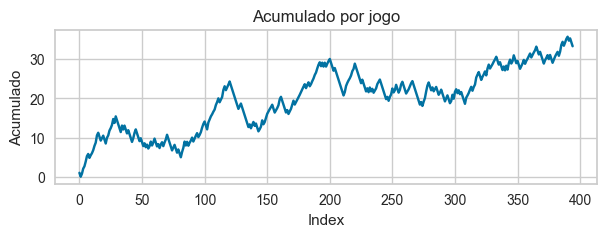

In [11]:
flt = 1

print('----------------- TREINO -----------------')
df_treinamento = info_modelo(treinamento, filtro = flt, show_info=True)



----------------- VALIDAÇÃO -----------------
PL: 9.66 | ROI: 11.78% | Prec.: 0.61
Odd média: 1.89 (0.53 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: 0.12
Máx Drawndown: -5.58
82 entradas em 4983 jogos (1.65%)


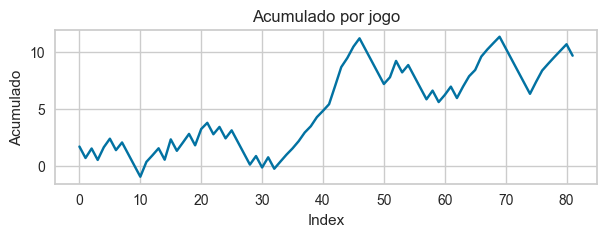

In [12]:
print('\n\n----------------- VALIDAÇÃO -----------------')
df_val = info_modelo(val, filtro = flt, show_info=True)

PL: 42.99 | ROI: 9.01% | Prec.: 0.59
Odd média: 1.89 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -12.74
477 entradas em 10521 jogos (4.53%)


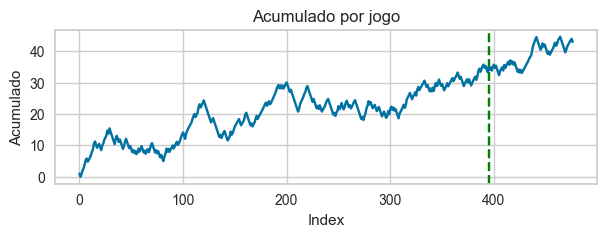

In [230]:
plt.axvline(x=len(pd.concat([df_treinamento])), color='green', linestyle='--')
completo = info_modelo(df, filtro = flt)

# QCut automático

In [ ]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_top_range(var, treino, teste, validacao, ratio = 3):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_neg_range(var, treino, teste, validacao):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = range
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict

In [ ]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

In [ ]:
variaveis = features.copy()
ranges_dict = {}

for var in variaveis:
    try:
        # new_dict = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.0)
        new_dict = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val)
        # new_dict = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3)
        ranges_dict[var] = new_dict
    except:
        pass

In [ ]:
for var in ranges_dict:
    print(f'{var}')
    print(f'ROI treino: {ranges_dict[var]["metric_treino"]["roi"]:.2f}')
    print(f'ROI teste: {ranges_dict[var]["metric_teste"]["roi"]:.2f}')
    print(f'ROI val: {ranges_dict[var]["metric_val"]["roi"]:.2f}')
    print(f'% Ent: {ranges_dict[var]["metric_treino"]["porc_ent"]:.2f}')
    print()

# Script qcut

In [165]:
# df_cut1 = df_treino.copy()
df_cut = df_treinamento.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [140]:
variaveis = features.copy()

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 7, duplicates='drop')

        target = TARGET
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['mean', 'count']
                                    )
        
        total_games = df_cut[target].count()

        pivot_table['percentage'] = (pivot_table[('count', target)] / total_games) * 100
        pivot_table['percentage'] = pivot_table['percentage'].round(2)

        # aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(pivot_table)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

P(H)
                    mean     count percentage
               Back_Home Back_Home           
Cat_P(H)                                     
(0.35, 0.435]   0.430894       123      16.94
(0.435, 0.488]  0.465116        86      11.85
(0.488, 0.546]  0.482759       116      15.98
(0.546, 0.575]  0.597938        97      13.36
(0.575, 0.602]  0.642857       112      15.43
(0.602, 0.633]  0.597938        97      13.36
(0.633, 0.649]  0.663158        95      13.09




------------------------------------------------



P(A)
                    mean     count percentage
               Back_Home Back_Home           
Cat_P(A)                                     
(0.376, 0.4]    0.663793       116      15.98
(0.4, 0.435]    0.626016       123      16.94
(0.435, 0.465]  0.612245        98      13.50
(0.465, 0.5]    0.573034        89      12.26
(0.5, 0.556]    0.463636       110      15.15
(0.556, 0.602]  0.417582        91      12.53
(0.602, 0.694]  0.464646        99      13.64




----------

In [ ]:
_df = _df[(_df['P_Diff'] > 0.0464) & (_df['P_Diff'] < 270)]